# POS Tagging - Língua Portuguesa

In [64]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from matplotlib import pyplot as plt
from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000
from nltk.corpus import floresta
import nltk.corpus
nltk.corpus.mac_morpho.words()
import seaborn as sns
from gensim.models import KeyedVectors
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [65]:
import nltk
nltk.download('machado')

[nltk_data] Downloading package machado to
[nltk_data]     C:\Users\rafae\AppData\Roaming\nltk_data...
[nltk_data]   Package machado is already up-to-date!


True

# 1. Carga de dados e pré-processamento

In [66]:
# Dados do NLTK
treebank_corpus = nltk.corpus.mac_morpho.tagged_sents()
brown_corpus = nltk.corpus.floresta.tagged_sents()
tagged_sentences = treebank_corpus + brown_corpus

In [67]:
# Visualizando dados
tagged_sentences[7]

[('A', 'ART'),
 ('Apinco', 'NPROP'),
 ('destaca', 'V'),
 ('em', 'PREP'),
 ('seu', 'PROADJ'),
 ('boletim', 'N'),
 ('mensal', 'ADJ'),
 ('que', 'KS'),
 ('o', 'ART'),
 ('setor', 'N'),
 ('avícola', 'ADJ'),
 ('está', 'V'),
 ('otimista', 'ADJ'),
 ('com', 'PREP'),
 ('o', 'ART'),
 ('atual', 'ADJ'),
 ('programa', 'N'),
 ('de', 'PREP'),
 ('estabilização', 'N'),
 ('econômica', 'ADJ')]

## Separação dos dados em palavras (X) e tags (Y)

In [68]:
X = [] # Armazenar entrada
Y = [] # Armazenar saída

for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # entity[0] contém palavra
        Y_sentence.append(entity[1])  # entity[1] contém tag
        
    X.append(X_sentence)
    Y.append(Y_sentence)

In [69]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

In [70]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 60663
Vocabulary size: 71569
Total number of tags: 341


In [71]:
# verificação de como os dados ficaram
# ponto de dados que será alimentado ao RNN
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

sample X:  ['Jersei', 'atinge', 'média', 'de', 'Cr$', '1,4', 'milhão', 'em', 'a', 'venda', 'de', 'a', 'Pinhal', 'em', 'São', 'Paulo'] 

sample Y:  ['N', 'V', 'N', 'PREP', 'CUR', 'NUM', 'N', 'PREP|+', 'ART', 'N', 'PREP|+', 'ART', 'NPROP', 'PREP', 'NPROP', 'NPROP'] 



In [72]:
# Neste problema muitos para muitos, o comprimento de cada seqüência de entrada e saída deve ser o mesmo
# Uma vez que cada palavra é marcada, é importante certificar-se de que o comprimento da sequência de entrada é igual à sequência de saída
print("Length of first input sequence  : {}".format(len(X[0])))
print("Length of first output sequence : {}".format(len(Y[0])))

Length of first input sequence  : 16
Length of first output sequence : 16


## Vetorizando X e Y

#### Codificar X e Y para valores inteiros

Será usada a função Tokenizer () da biblioteca Keras para codificar a sequência de texto em sequência inteira

In [73]:
# codificando X

word_tokenizer = Tokenizer()                      # instanciar o tokeniser
word_tokenizer.fit_on_texts(X)                    # ajustando dados
X_encoded = word_tokenizer.texts_to_sequences(X)  # codificar sequencia de entrada

In [74]:
# codificando Y

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [75]:
# primeiro conjunto codificado

print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['Jersei', 'atinge', 'média', 'de', 'Cr$', '1,4', 'milhão', 'em', 'a', 'venda', 'de', 'a', 'Pinhal', 'em', 'São', 'Paulo'] 

Y:  ['N', 'V', 'N', 'PREP', 'CUR', 'NUM', 'N', 'PREP|+', 'ART', 'N', 'PREP|+', 'ART', 'NPROP', 'PREP', 'NPROP', 'NPROP'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [15505, 3009, 208, 1, 192, 7360, 759, 5, 2, 433, 1, 2, 15506, 5, 26, 50] 

Y:  [1, 5, 1, 4, 40, 17, 1, 7, 2, 1, 7, 2, 3, 4, 3, 3] 



In [76]:
# cada sequência de entrada e saída tem o mesmo comprimento

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


## Sequencias

A próxima etapa após codificar os dados é definir os comprimentos da sequência. A partir de agora, as frases presentes nos dados têm vários comprimentos. Precisamos preencher frases curtas ou truncar frases longas para um comprimento fixo. Esse comprimento fixo, no entanto, é um hiperparâmetro.

In [77]:
# comprimento da frase mais longa
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 617


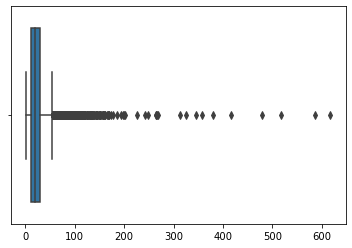

In [78]:
sns.boxplot(lengths)
plt.show()

In [79]:
# Preencha cada sequência para MAX_SEQ_LENGTH usando a função pad_sequences () de KERAS.
# Frases com mais de MAX_SEQ_LENGTH são truncadas.
# Frases menores que MAX_SEQ_LENGTH são preenchidas com zeros.

# O truncamento e o preenchimento podem ser 'pré' ou 'pós'.
# Para preenchimento, estamos usando o tipo de preenchimento 'pré', ou seja, adicionar zeros no lado esquerdo.
# Para truncamento, estamos usando 'post', ou seja, truncar uma frase do lado direito.

MAX_SEQ_LENGTH = 70  # sequências maiores que 100 de comprimento serão truncadas

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [80]:
# mostrando primeira sequencia
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0 15505  3009   208     1   192  7360
   759     5     2   433     1     2 15506     5    26    50] 



[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  1  5  1  4 40 17  1  7  2  1  7  2  3  4  3  3]


RNN aprenderá o mapeamento de zero a zero durante o treinamento. Portanto, não precisamos nos preocupar com os zeros preenchidos. Observe que o zero não é reservado para nenhuma palavra ou tag, ele é reservado apenas para preenchimento.

In [81]:
# atribuir sequências preenchidas a X e Y
X, Y = X_padded, Y_padded

## Word embeddings

Atualmente, cada palavra e cada tag é codificada como um número inteiro.

Usaremos uma técnica mais sofisticada para representar as palavras de entrada (X) usando o que é conhecido como embeddings de palavras.

No entanto, para representar cada tag em Y, vamos simplesmente usar o esquema one-hot encoding, pois há apenas 13 tags no conjunto de dados e o LSTM não terá problemas em aprender sua própria representação dessas tags.

### Use embeddings de palavras para sequências de entrada (X)

In [82]:
word2vec = KeyedVectors.load_word2vec_format(r'D:\HD 1TB\Downloads Google Chrome\glove_s50\glove_s50.txt')

In [84]:
# atribuir vetores de palavras do modelo word2vec

EMBEDDING_SIZE  = 50  # cada palavra no modelo word2vec é representada usando um vetor de 50 dimensões
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# matriz vazia
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# criar uma palavra para indexar o mapeamento do dicionário
word2id = word_tokenizer.word_index

# vetores do modelo word2vec para as palavras presentes no corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [85]:
# verificar dimensão
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (71570, 50)


### Use one-hot encoding for output sequences (Y)

In [87]:
# função to_categorical de Keras para codificar Y
Y = to_categorical(Y)

In [88]:
# Y da primeira sequência de saída
print(Y.shape)

(60663, 70, 342)


## Dados em conjuntos de treinamento, validação e teste

In [89]:
# dividir todos os dados em conjuntos de treinamento e teste
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)

In [90]:
# dividir os dados de treinamento em conjuntos de treinamento e validação
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

In [91]:
# imprimir o número de amostras em cada conjunto
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (43828, 70)
Shape of output sequences: (43828, 70, 342)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (7735, 70)
Shape of output sequences: (7735, 70, 342)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (9100, 70)
Shape of output sequences: (9100, 70, 342)


# 2. Vanilla RNN

### Embeddings fixos não inicializados
Primeiro, vamos tentar executar um RNN vanilla. Para este RNN não usaremos embeddings de palavras pré-treinadas. Usaremos embeddings inicializados aleatoriamente. Além disso, não atualizaremos os pesos dos embeddings.

In [92]:
# numero de tags
NUM_CLASSES = Y.shape[2]

In [93]:
# criação da arquitetura

rnn_model = Sequential()

# criar camada de incorporação - geralmente a primeira camada em problemas de texto
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # tamanho do vocabulário - número de palavras únicas nos dados
                        output_dim    =  EMBEDDING_SIZE,          # comprimento do vetor com o qual cada palavra é representada
                        input_length  =  MAX_SEQ_LENGTH,          # comprimento da sequência de entrada
                        trainable     =  False                    # False - não atualize os embeddings
))

# adicionar uma camada RNN que contém 64 células RNN
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # Verdadeiro - retorna a sequência inteira; Falso - retorna uma única saída do final da sequência
))

# adicionar camada distribuída no tempo (saída em cada sequência)
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile modelo

In [94]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [95]:
# resumo do modelo
rnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 70, 50)            3578500   
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 70, 64)            7360      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 70, 342)           22230     
Total params: 3,608,090
Trainable params: 29,590
Non-trainable params: 3,578,500
_________________________________________________________________


## Fit modelo

In [96]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_data=(X_validation, Y_validation))

Epoch 1/20
343/343 [==============================] - 81s 228ms/step - loss: 2.6803 - acc: 0.5694 - val_loss: 1.2599 - val_acc: 0.6798
Epoch 2/20
343/343 [==============================] - 81s 235ms/step - loss: 1.2878 - acc: 0.7063 - val_loss: 1.2527 - val_acc: 0.7174
Epoch 3/20
343/343 [==============================] - 83s 243ms/step - loss: 1.1333 - acc: 0.7264 - val_loss: 1.0573 - val_acc: 0.7321
Epoch 4/20
343/343 [==============================] - 84s 246ms/step - loss: 1.0611 - acc: 0.7314 - val_loss: 0.9779 - val_acc: 0.7735
Epoch 5/20
343/343 [==============================] - 79s 231ms/step - loss: 0.9576 - acc: 0.7764 - val_loss: 0.8656 - val_acc: 0.7858
Epoch 6/20
343/343 [==============================] - 78s 226ms/step - loss: 0.8436 - acc: 0.7882 - val_loss: 0.7834 - val_acc: 0.7978
Epoch 7/20
343/343 [==============================] - 77s 223ms/step - loss: 0.7806 - acc: 0.7987 - val_loss: 0.7289 - val_acc: 0.8092
Epoch 8/20
343/343 [==============================] - 7

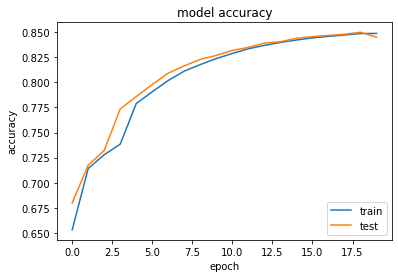

In [97]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

### Embeddings treináveis não inicializados

In [98]:
# criação da arquitetura

rnn_model = Sequential()

rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,        
                        output_dim    =  EMBEDDING_SIZE,          
                        input_length  =  MAX_SEQ_LENGTH,          
                        trainable     =  True                     
))


rnn_model.add(SimpleRNN(64, 
              return_sequences=True  
))

rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile model

In [99]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [100]:
rnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 70, 50)            3578500   
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 70, 64)            7360      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 70, 342)           22230     
Total params: 3,608,090
Trainable params: 3,608,090
Non-trainable params: 0
_________________________________________________________________


## Fit modelo

In [101]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_data=(X_validation, Y_validation))

Epoch 1/20
343/343 [==============================] - 96s 270ms/step - loss: 2.4430 - acc: 0.6626 - val_loss: 0.7736 - val_acc: 0.8156
Epoch 2/20
343/343 [==============================] - 89s 258ms/step - loss: 0.6197 - acc: 0.8499 - val_loss: 0.3660 - val_acc: 0.9050
Epoch 3/20
343/343 [==============================] - 75s 218ms/step - loss: 0.3292 - acc: 0.9122 - val_loss: 0.2871 - val_acc: 0.9173
Epoch 4/20
343/343 [==============================] - 59s 172ms/step - loss: 0.2587 - acc: 0.9237 - val_loss: 0.2377 - val_acc: 0.9296
Epoch 5/20
343/343 [==============================] - 59s 171ms/step - loss: 0.1990 - acc: 0.9407 - val_loss: 0.2186 - val_acc: 0.9343
Epoch 6/20
343/343 [==============================] - 58s 168ms/step - loss: 0.1644 - acc: 0.9499 - val_loss: 0.2124 - val_acc: 0.9356
Epoch 7/20
343/343 [==============================] - 58s 169ms/step - loss: 0.1452 - acc: 0.9547 - val_loss: 0.2092 - val_acc: 0.9360
Epoch 8/20
343/343 [==============================] - 5

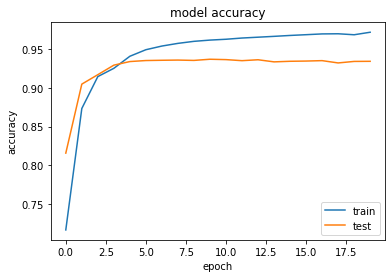

In [102]:
# visualizar histórico de treinamento
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

### Usando pesos de incorporação pré-treinados

In [103]:

rnn_model = Sequential()

rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         
                        output_dim    =  EMBEDDING_SIZE,          
                        input_length  =  MAX_SEQ_LENGTH,          
                        weights       = [embedding_weights],     
                        trainable     =  True                     
))


rnn_model.add(SimpleRNN(64, 
              return_sequences=True  
))

rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile model

In [104]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [105]:
rnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 70, 50)            3578500   
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 70, 64)            7360      
_________________________________________________________________
time_distributed_8 (TimeDist (None, 70, 342)           22230     
Total params: 3,608,090
Trainable params: 3,608,090
Non-trainable params: 0
_________________________________________________________________


## Fit modelo

In [106]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_data=(X_validation, Y_validation))

Epoch 1/20
343/343 [==============================] - 61s 172ms/step - loss: 2.1870 - acc: 0.7031 - val_loss: 0.4678 - val_acc: 0.8824
Epoch 2/20
343/343 [==============================] - 59s 173ms/step - loss: 0.4130 - acc: 0.8923 - val_loss: 0.3151 - val_acc: 0.9113
Epoch 3/20
343/343 [==============================] - 59s 171ms/step - loss: 0.2942 - acc: 0.9153 - val_loss: 0.2562 - val_acc: 0.9244
Epoch 4/20
343/343 [==============================] - 59s 172ms/step - loss: 0.2308 - acc: 0.9319 - val_loss: 0.2244 - val_acc: 0.9325
Epoch 5/20
343/343 [==============================] - 59s 172ms/step - loss: 0.1989 - acc: 0.9399 - val_loss: 0.2136 - val_acc: 0.9343
Epoch 6/20
343/343 [==============================] - 58s 170ms/step - loss: 0.1706 - acc: 0.9475 - val_loss: 0.2173 - val_acc: 0.9311
Epoch 7/20
343/343 [==============================] - 60s 175ms/step - loss: 0.1578 - acc: 0.9504 - val_loss: 0.2140 - val_acc: 0.9366
Epoch 8/20
343/343 [==============================] - 6

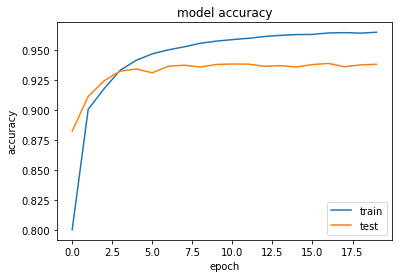

In [107]:
# visualizar histórico de treinamento
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

# 2. LSTM

Usaremos embeddings de palavras pré-treinados nos modelos a seguir e permitiremos que eles sejam atualizados também.

## Arquitetura

In [108]:

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         
                         output_dim    = EMBEDDING_SIZE,          
                         input_length  = MAX_SEQ_LENGTH,          
                         weights       = [embedding_weights],     
                         trainable     = True                     
))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile modelo

In [109]:
lstm_model.compile(loss      =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])

In [110]:
lstm_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 70, 50)            3578500   
_________________________________________________________________
lstm_2 (LSTM)                (None, 70, 64)            29440     
_________________________________________________________________
time_distributed_9 (TimeDist (None, 70, 342)           22230     
Total params: 3,630,170
Trainable params: 3,630,170
Non-trainable params: 0
_________________________________________________________________


## Fit modelo

In [111]:
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_data=(X_validation, Y_validation))

Epoch 1/20
343/343 [==============================] - 76s 204ms/step - loss: 2.5615 - acc: 0.7417 - val_loss: 0.6519 - val_acc: 0.8371
Epoch 2/20
343/343 [==============================] - 68s 198ms/step - loss: 0.5590 - acc: 0.8643 - val_loss: 0.3807 - val_acc: 0.9015
Epoch 3/20
343/343 [==============================] - 69s 202ms/step - loss: 0.3541 - acc: 0.9060 - val_loss: 0.3088 - val_acc: 0.9118
Epoch 4/20
343/343 [==============================] - 69s 200ms/step - loss: 0.2936 - acc: 0.9146 - val_loss: 0.2688 - val_acc: 0.9175
Epoch 5/20
343/343 [==============================] - 69s 201ms/step - loss: 0.2450 - acc: 0.9249 - val_loss: 0.2375 - val_acc: 0.9282
Epoch 6/20
343/343 [==============================] - 69s 200ms/step - loss: 0.2115 - acc: 0.9363 - val_loss: 0.2209 - val_acc: 0.9326
Epoch 7/20
343/343 [==============================] - 69s 201ms/step - loss: 0.1862 - acc: 0.9429 - val_loss: 0.2128 - val_acc: 0.9349
Epoch 8/20
343/343 [==============================] - 6

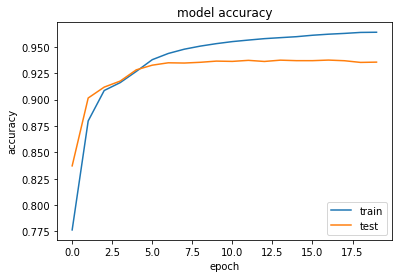

In [112]:
# visualizar histórico de treinamento
plt.plot(lstm_training.history['acc'])
plt.plot(lstm_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

# 2. GRU

## Arquitetura

In [113]:
# create architecture

gru_model = Sequential()
gru_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                        output_dim    = EMBEDDING_SIZE,
                        input_length  = MAX_SEQ_LENGTH,
                        weights       = [embedding_weights],
                        trainable     = True
))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile modelo

In [114]:
gru_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [115]:
gru_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 70, 50)            3578500   
_________________________________________________________________
gru_1 (GRU)                  (None, 70, 64)            22272     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 70, 342)           22230     
Total params: 3,623,002
Trainable params: 3,623,002
Non-trainable params: 0
_________________________________________________________________


## Fit modelo

In [116]:
gru_training = gru_model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_data=(X_validation, Y_validation))

Epoch 1/20
343/343 [==============================] - 67s 187ms/step - loss: 2.4354 - acc: 0.7585 - val_loss: 0.5093 - val_acc: 0.8736
Epoch 2/20
343/343 [==============================] - 63s 184ms/step - loss: 0.4308 - acc: 0.8900 - val_loss: 0.3180 - val_acc: 0.9100
Epoch 3/20
343/343 [==============================] - 63s 184ms/step - loss: 0.2986 - acc: 0.9132 - val_loss: 0.2648 - val_acc: 0.9196
Epoch 4/20
343/343 [==============================] - 63s 185ms/step - loss: 0.2450 - acc: 0.9255 - val_loss: 0.2235 - val_acc: 0.9308
Epoch 5/20
343/343 [==============================] - 63s 185ms/step - loss: 0.1997 - acc: 0.9372 - val_loss: 0.2038 - val_acc: 0.9353
Epoch 6/20
343/343 [==============================] - 63s 185ms/step - loss: 0.1690 - acc: 0.9457 - val_loss: 0.1956 - val_acc: 0.9363
Epoch 7/20
343/343 [==============================] - 63s 185ms/step - loss: 0.1502 - acc: 0.9506 - val_loss: 0.1954 - val_acc: 0.9374
Epoch 8/20
343/343 [==============================] - 6

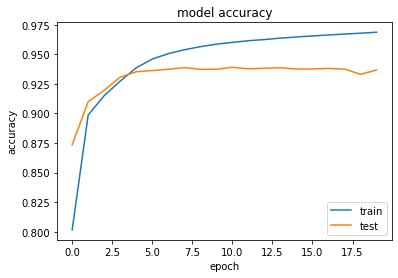

In [117]:
# visualizar histórico de treinamento
plt.plot(gru_training.history['acc'])
plt.plot(gru_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

# 3. Bidirectional LSTM

## Arquitetura

In [118]:
bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile modelo

In [119]:
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [120]:
bidirect_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 70, 50)            3578500   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 70, 128)           58880     
_________________________________________________________________
time_distributed_11 (TimeDis (None, 70, 342)           44118     
Total params: 3,681,498
Trainable params: 3,681,498
Non-trainable params: 0
_________________________________________________________________


## Fit modelo

In [121]:
bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_data=(X_validation, Y_validation))

Epoch 1/20
343/343 [==============================] - 91s 247ms/step - loss: 2.0327 - acc: 0.7444 - val_loss: 0.4268 - val_acc: 0.8955
Epoch 2/20
343/343 [==============================] - 86s 250ms/step - loss: 0.3581 - acc: 0.9118 - val_loss: 0.1874 - val_acc: 0.9551
Epoch 3/20
343/343 [==============================] - 89s 260ms/step - loss: 0.1696 - acc: 0.9589 - val_loss: 0.1390 - val_acc: 0.9650
Epoch 4/20
343/343 [==============================] - 86s 252ms/step - loss: 0.1253 - acc: 0.9685 - val_loss: 0.1169 - val_acc: 0.9702
Epoch 5/20
343/343 [==============================] - 88s 257ms/step - loss: 0.1047 - acc: 0.9735 - val_loss: 0.1035 - val_acc: 0.9728
Epoch 6/20
343/343 [==============================] - 87s 255ms/step - loss: 0.0868 - acc: 0.9775 - val_loss: 0.0941 - val_acc: 0.9750
Epoch 7/20
343/343 [==============================] - 87s 253ms/step - loss: 0.0760 - acc: 0.9800 - val_loss: 0.0893 - val_acc: 0.9762
Epoch 8/20
343/343 [==============================] - 8

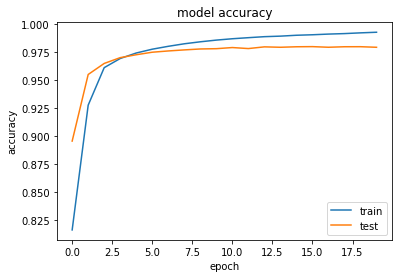

In [122]:
# visualizar histórico de treinamento
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

# 5. Model evaluation

In [123]:
loss, accuracy = rnn_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

285/285 [==============================] - 4s 12ms/step - loss: 0.2309 - acc: 0.9384
Loss: 0.2309294492006302,
Accuracy: 0.9383987188339233


In [124]:
loss, accuracy = lstm_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

285/285 [==============================] - 6s 22ms/step - loss: 0.2445 - acc: 0.9349
Loss: 0.24453984200954437,
Accuracy: 0.93489009141922


In [125]:
loss, accuracy = gru_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

285/285 [==============================] - 5s 16ms/step - loss: 0.2454 - acc: 0.9370
Loss: 0.24537524580955505,
Accuracy: 0.9370360970497131


In [126]:
loss, accuracy = bidirect_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

285/285 [==============================] - 6s 21ms/step - loss: 0.0889 - acc: 0.9786
Loss: 0.08889485150575638,
Accuracy: 0.9786248207092285
